# Figure for a talk about context of exoplanets

gully, Jan 13, 2023

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import pandas as pd
import os
import glob
from astropy.io import fits
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.time import Time
import lightkurve as lk
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
import astropy.constants as const


%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_context('paper')

from pandas.core.common import SettingWithCopyWarning

sns.set_context('talk')
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Download the Exoplanet Archive 
"Planetary Systems Composite Data"

In [3]:
#! mv /home/gully/Downloads/PSCompPars_2023.01.13_12.58.07.votable ../../data/ExoplanetArchive/

In [4]:
table_1 = Table.read('../../data/ExoplanetArchive/PSCompPars_2023.01.13_12.58.07.votable',format='votable')

In [5]:
df_orig = table_1.to_pandas()

In [6]:
df_orig.shape

(5241, 313)

In [7]:
pd.options.display.max_rows=999

Keep just a few important columns for now

In [8]:
all_cols = df_orig.columns.values

In [9]:
keep_cols = [col for col in all_cols if 'err1' not in col]
keep_cols = [col for col in keep_cols if 'err2' not in col]
keep_cols = [col for col in keep_cols if '_reflink' not in col]
keep_cols = [col for col in keep_cols if 'lim' not in col]
keep_cols = [col for col in keep_cols if 'mag' not in col]
keep_cols = [col for col in keep_cols if 'disc_' not in col]
keep_cols = [col for col in keep_cols if '_flag' not in col]

In [10]:
df_orig = df_orig[keep_cols]

In [11]:
df_orig.shape

(5241, 70)

Let's compute the planet surface gravity:

In [12]:
grav = const.G * (df_orig.pl_bmasse.values * u.M_earth) / (df_orig.pl_rade.values * u.R_earth)**2
df_orig['pl_grav'] = grav.to(u.m/u.s**2).value
df_orig['pl_grave'] = df_orig.pl_grav/9.8

### Read in the Solar System fact sheet for comparison
From [this website](https://nssdc.gsfc.nasa.gov/planetary/factsheet/)

In [13]:
df = pd.read_csv('../../data/solar_system/ss_data_fact_sheet_nasa.csv', 
            sep='\t', skipfooter=1, engine='python', 
            na_values=['Unknown*', 'Unknown']).set_index('Unnamed: 0').T

df.index.name = 'Planet'
df.columns.name = None
df = df.reset_index()
df = df.drop(index=3).reset_index() # Drop the moon
df = df.drop(index=8).reset_index() # Drop Pluto @PlutoKiller

In [14]:
df['pl_rade'] = (df['Diameter (km)'].str.replace(',', '').astype(float).values/2*\
                 1*u.km/(1*u.Rearth)).to(u.dimensionless_unscaled).value

In [15]:
df['pl_bmasse'] = (df['Mass (1024kg)'].astype(float).values*1e24*\
                 1*u.kg/(1*u.M_earth)).to(u.dimensionless_unscaled).value

In [16]:
df['pl_grave'] = df['Gravity (m/s2)'].astype(float).values/9.8

In [17]:
df['pl_orbsmax'] = (df['Distance from Sun (106 km)'].astype(float).values*1e6 *\
                     1*u.km/(1*u.AU)).to(u.dimensionless_unscaled).value

In [18]:
df = df[['Planet']+df.columns[-4:].values.tolist()]

In [19]:
df['pl_insol'] = 1/df.pl_orbsmax**2

In [20]:
df['Initial'] = ['Me','V', 'E','Ma','J','S','U','N']

### Pick some special objects from the Exoplanet Archive

In [21]:
s1 = df_orig[df_orig.hostname.str.contains('HAT-P-67')].iloc[0]

In [22]:
s2 = df_orig[df_orig.hostname.str.contains('189733')].iloc[0]

In [23]:
s3 = df_orig[df_orig.hostname.str.contains('HAT-P-32')].iloc[0]

In [126]:
inflated_hot_jup_names = ['HAT-P-1 b','CoRoT-1 b', 'TrES-4 b', 'WASP-12 b', 'WASP-17 b', 'Kepler-7 b']

In [129]:
inflated_hot_jup_mask = df_orig.pl_name.isin(inflated_hot_jup_names)

In [130]:
df_orig.pl_name[inflated_hot_jup_mask]

79       CoRoT-1 b
304      HAT-P-1 b
4160    Kepler-7 b
4982      TrES-4 b
5014     WASP-12 b
5061     WASP-17 b
Name: pl_name, dtype: object

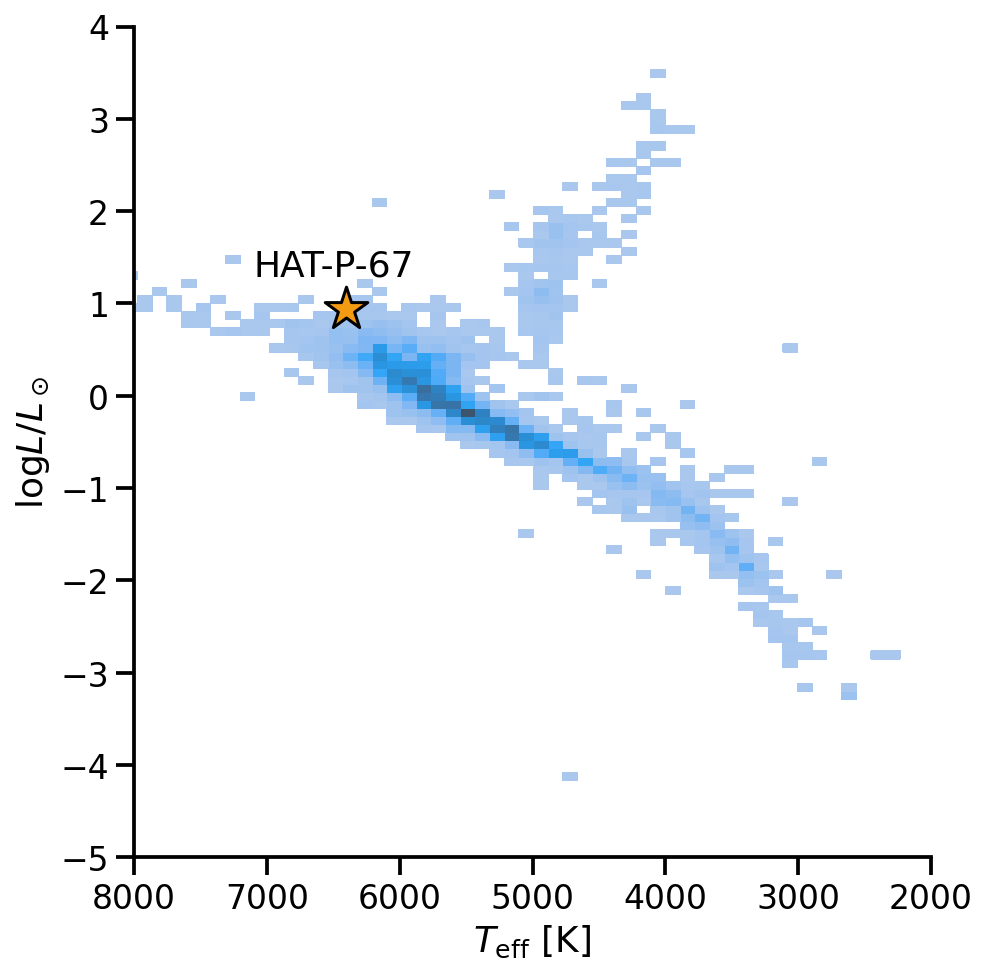

In [24]:
grid = sns.displot(x=df_orig.st_teff, y=df_orig.st_lum, height=7, alpha=1)
#grid.ax.plot(df_orig.st_teff,df_orig.st_lum,'.',alpha=1) #hr diagram

grid.ax.scatter(s1.st_teff, s1.st_lum, marker='*', color='#f39c12', s=500, ec='k', 
               label='HAT-P-67')

grid.ax.text(7100, 1.3, 'HAT-P-67')

grid.ax.set_xlim(8000,2000)
grid.ax.set_ylim(-5,4)
grid.ax.set_xscale('linear')
grid.ax.set_xlabel('$T_\mathrm{eff}$ [K]' )
grid.ax.set_ylabel('$\log{L/L_\odot}$')

plt.savefig('../../figures/ExoArchive_HRD2023_hist_HAT.png', dpi=300, bbox_inches='tight')

In [25]:
jupiter_insolation = (1/5.2038)**2
jupiter_gravity = 24.79 # m/s

In [26]:
mask = df_orig.hostname.str.contains('TRAPPIST-1')
mask.sum()

7

In [136]:
s1

rowid                                            369
pl_name                                   HAT-P-67 b
hostname                                    HAT-P-67
pl_letter                                          b
hd_name                                             
hip_name                                            
tic_id                                 TIC 198588220
gaia_id                 Gaia DR2 1358614983131339392
sy_snum                                            2
sy_pnum                                            1
sy_mnum                                            0
discoverymethod                              Transit
pl_orbper                                   4.810103
pl_orbsmax                                   0.06505
pl_rade                                       23.371
pl_radj                                        2.085
pl_bmasse                                   108.0622
pl_bmassj                                       0.34
pl_bmassprov                                  

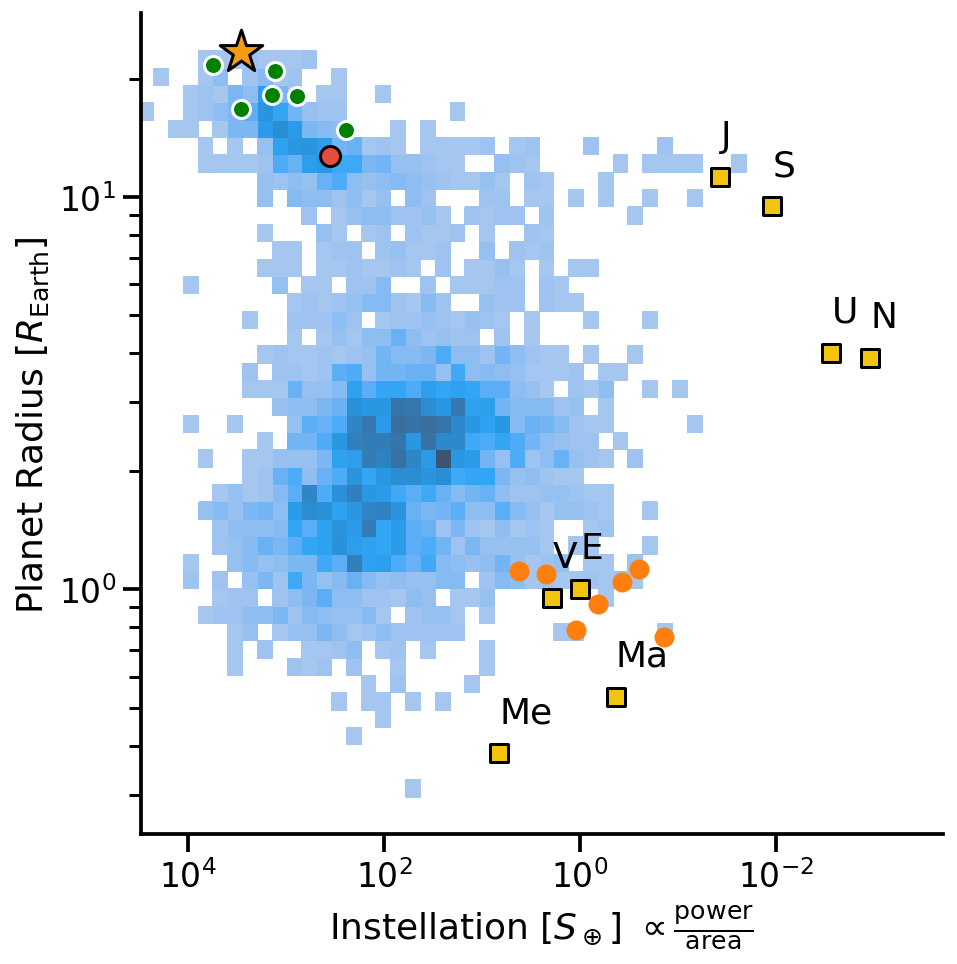

In [134]:
grid = sns.displot(x=df_orig.pl_insol, y=df_orig.pl_rade, height=7, alpha=1, log_scale=True)
grid.ax.plot(df_orig.pl_insol,df_orig.pl_rade,'.',alpha=0.0, zorder=-1)

grid.ax.set_xlabel(r'Instellation [$S_\oplus$] $\propto \frac{\mathrm{power}}{\mathrm{area}}$' )
grid.ax.set_ylabel('Planet Radius [$R_\mathrm{Earth}$]');


grid.ax.scatter(s1.pl_insol, s1.pl_rade, marker='*', color='#f39c12', s=500, ec='k', 
               label='HAT-P-67')
#grid.ax.text(8_000, 3, 'HAT-P-67 b')

grid.ax.scatter(s2.pl_insol, s2.pl_rade, marker='o', color='#e74c3c', s=100, ec='k', 
               label='HD 189733 b')
#grid.ax.text(900, 30, 'HD 189733 b', color='w', fontsize=14)


grid.ax.scatter(df.pl_insol, df.pl_rade, marker='s', color='#f1c40f', ec='k')
for i in range(len(df)):
    planet = df.iloc[i]
    plt.annotate(planet.Initial, (planet.pl_insol, planet.pl_rade *1.2))

grid.ax.scatter(df_orig.pl_insol[inflated_hot_jup_mask], df_orig.pl_rade[inflated_hot_jup_mask],
           marker='o', color='g', ec='w', zorder=10)

grid.ax.plot(df_orig.pl_insol[mask],df_orig.pl_rade[mask],'o',alpha=1, zorder=1)


grid.ax.set_xlim(3e4,2e-4)
#grid.ax.set_ylim(6,2)
grid.ax.set_xscale('log')

In [135]:
s1

rowid                                            369
pl_name                                   HAT-P-67 b
hostname                                    HAT-P-67
pl_letter                                          b
hd_name                                             
hip_name                                            
tic_id                                 TIC 198588220
gaia_id                 Gaia DR2 1358614983131339392
sy_snum                                            2
sy_pnum                                            1
sy_mnum                                            0
discoverymethod                              Transit
pl_orbper                                   4.810103
pl_orbsmax                                   0.06505
pl_rade                                       23.371
pl_radj                                        2.085
pl_bmasse                                   108.0622
pl_bmassj                                       0.34
pl_bmassprov                                  

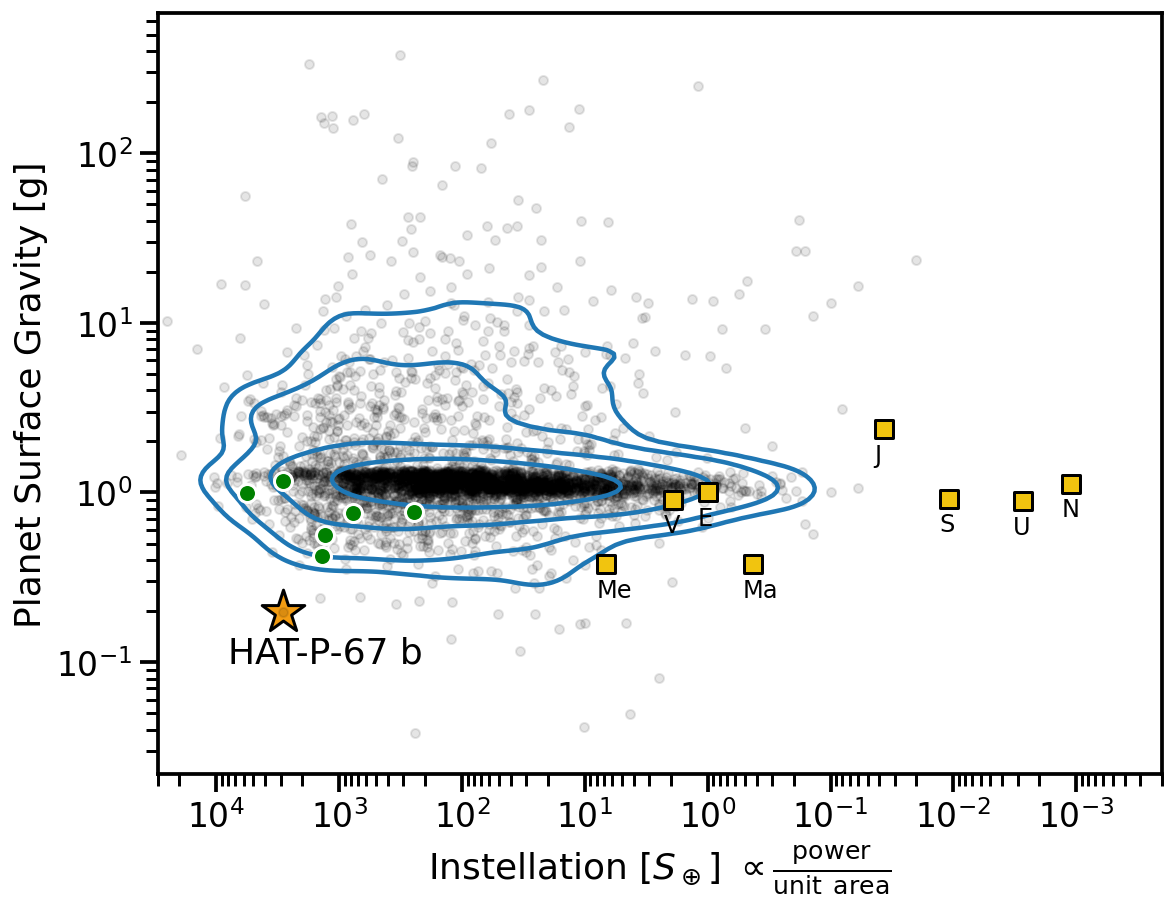

In [132]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.kdeplot(x=df_orig.pl_insol, y=df_orig.pl_grave, alpha=1, shade=False,
                   log_scale=True, zorder=2, ax=ax, levels=[0.05, 0.1, 0.25, 0.5, ])

ax.plot(df_orig.pl_insol,df_orig.pl_grave,'.',alpha=0.1, zorder=1, color='k')

ax.scatter(s1.pl_insol, s1.pl_grave, marker='*', color='#f39c12', s=500, ec='k', 
               label='HAT-P-67')
ax.text(8_000, 0.1, 'HAT-P-67 b')

#grid.ax.scatter(s2.pl_insol, 21.2, marker='o', color='#e74c3c', s=100, ec='k', 
#               label='HD 189733 b')
#grid.ax.text(900, 30, 'HD 189733 b', color='w', fontsize=14)

ax.scatter(df.pl_insol, df.pl_grave, marker='s', color='#f1c40f', ec='k', zorder=10)
for i in range(len(df)):
    planet = df.iloc[i]
    plt.annotate(planet.Initial, (planet.pl_insol*1.2, planet.pl_grave /1.55), fontsize=12, zorder=10)


ax.scatter(df_orig.pl_insol[inflated_hot_jup_mask], df_orig.pl_grave[inflated_hot_jup_mask],
           marker='o', color='g', ec='w', zorder=10)
#for i in range(len(df)):
#    planet = df.iloc[i]
#    plt.annotate(planet.Initial, (planet.pl_insol*1.2, planet.pl_grave /1.55), fontsize=12, zorder=10)



ax.set_xlim(3e4,2e-4)
#grid.ax.set_ylim(6,2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Instellation [$S_\oplus$] $\propto \frac{\mathrm{power}}{\mathrm{unit\,\;area}}$' )
ax.set_ylabel('Planet Surface Gravity [g]');

#plt.savefig('../../figures/ExoArchive_HRD2023_hist_HAT.png', dpi=300, bbox_inches='tight')

### Surface gravity versus mass

Visualizing [this pileup](https://ui.adsabs.harvard.edu/abs/2016AsBio..16..325B/abstract)

(0.01, 100.0)

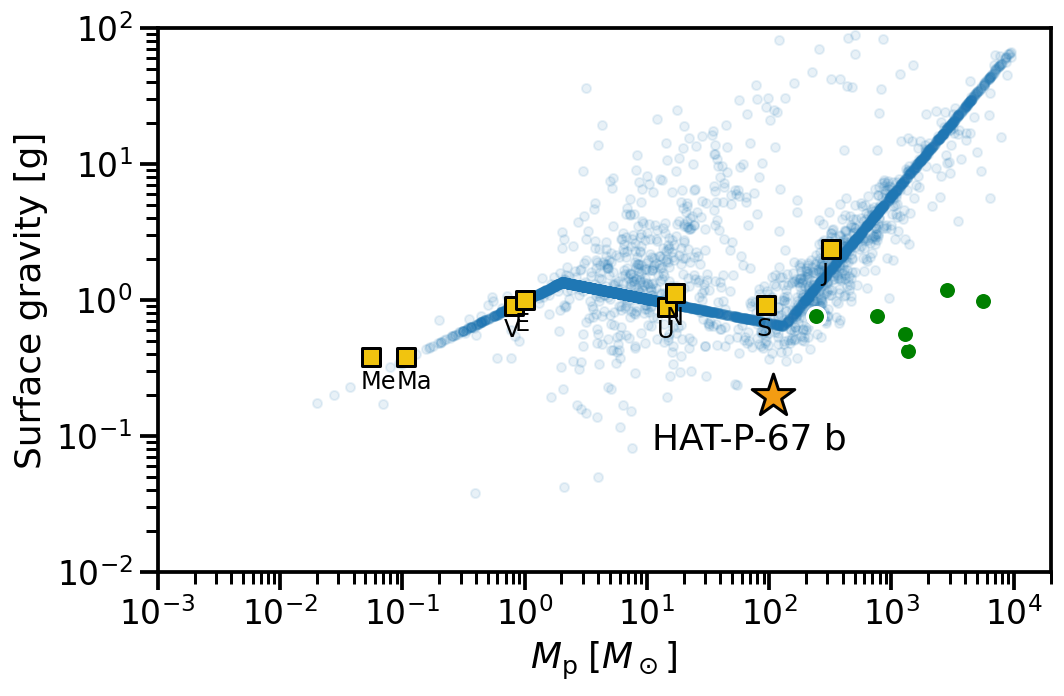

In [133]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(df_orig.pl_bmasse,df_orig.pl_grave,'.',alpha=0.1, zorder=-1)


ax.scatter(df.pl_bmasse, df.pl_grave, marker='s', color='#f1c40f', ec='k', zorder=10)
for i in range(len(df)):
    planet = df.iloc[i]
    plt.annotate(planet.Initial, (planet.pl_bmasse/1.2, planet.pl_grave /1.7), fontsize=12, zorder=10)

ax.scatter(df_orig.pl_insol[inflated_hot_jup_mask], df_orig.pl_grave[inflated_hot_jup_mask],
           marker='o', color='g', ec='w', zorder=10)

ax.scatter(s1.pl_bmasse, s1.pl_grave, marker='*', color='#f39c12', s=500, ec='k', 
               label='HAT-P-67')
ax.text(11, 0.08, 'HAT-P-67 b')

ax.set_xlabel('$M_\mathrm{p}\; [M_\odot]$')
ax.set_ylabel('Surface gravity [g]')
ax.set_xscale('log')
ax.set_xlim(1e-3, 2e4)
ax.set_yscale('log')
ax.set_ylim(1e-2, 1e2)

In [ ]:
grid.ax.plot(df_orig.pl_insol[mask],df_orig.pl_grav[mask],'o',alpha=1, zorder=1)

grid.ax.scatter(s1.pl_insol, s1.pl_grav, marker='*', color='#f39c12', s=500, ec='k', 
               label='HAT-P-67')
grid.ax.text(8_000, 3, 'HAT-P-67 b')

grid.ax.scatter(s2.pl_insol, s1.pl_grav, marker='o', color='#e74c3c', s=100, ec='k', 
               label='HD 189733 b')
#grid.ax.text(900, 30, 'HD 189733 b', color='w', fontsize=14)

grid.ax.scatter(1, 9.8, marker='o', ec='k', s=100, color='#27ae60', 
               label='Earth')
grid.ax.scatter(1, 9.8, marker='+', s=100, color='k', 
               label='Earth')

grid.ax.scatter(jupiter_insolation, jupiter_gravity, marker='s', s=100, color='#9b59b6', ec='k',
               label='Jupiter')



grid.ax.set_xlim(3e4,1e-2)
#grid.ax.set_ylim(6,2)
grid.ax.set_xscale('log')
grid.ax.set_yscale('log')
grid.ax.set_xlabel(r'Instellation [$S/S_\oplus$] $\propto \frac{\mathrm{power}}{\mathrm{area}}$' )
grid.ax.set_ylabel('Planet Surface Gravity [m/s$^2$]');

#plt.savefig('../../figures/ExoArchive_HRD2023_hist_HAT.png', dpi=300, bbox_inches='tight')

(-5.0, 250.0)

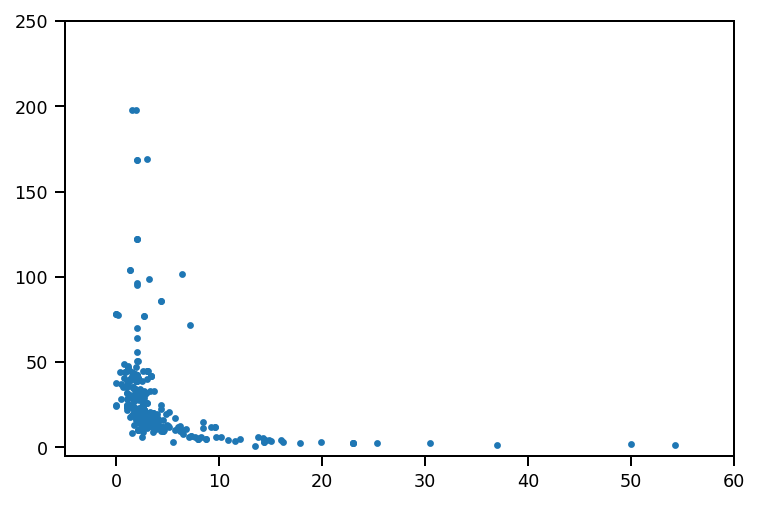

In [17]:
plt.plot(df_orig.st_vsin,df_orig.st_rotp,'.')
plt.xlim(-5,60)
plt.ylim(-5,250) #inversely relates

In [15]:
df_orig.hostname.value_counts() #duplicates? merged values,see how many planets in system with hostname

KOI-351              8
TRAPPIST-1           7
HD 34445             6
Kepler-20            6
Kepler-11            6
                    ..
NGC 2682 Sand 364    1
Kepler-1392          1
Kepler-1253          1
Kepler-1680          1
Kepler-1430          1
Name: hostname, Length: 3254, dtype: int64

In [6]:
df=df_orig[['hostname','st_teff','st_rad','st_mass','st_logg','sy_refname','ra','dec']] #need rv, vsini
df

,hostname,st_teff,st_rad,st_mass,st_logg,sy_refname,ra,dec
0,11 Com,NaN,NaN,2.60,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,185.178772,17.793251
1,11 Com,4742.0,19.00,2.70,2.31,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,185.178772,17.793251
2,11 UMi,4340.0,24.08,1.80,1.60,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,229.274597,71.823944
3,11 UMi,NaN,NaN,1.70,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,229.274597,71.823944
4,11 UMi,4213.0,29.79,2.78,1.93,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,229.274597,71.823944
...,...,...,...,...,...,...,...,...
29382,ups And,NaN,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,24.198353,41.403816
29383,ups And,NaN,1.56,1.30,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,24.198353,41.403816
29384,ups And,NaN,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,24.198353,41.403816
29385,xi Aql,4780.0,12.00,2.20,2.66,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,298.562439,8.461105


In [8]:
hat_p_32_coord = '02 04 10.2775457769 +46 41 16.210382751'

In [14]:
coordinates = SkyCoord(hat_p_32_coord,unit=(u.hourangle,u.deg))

In [15]:
catalog = SkyCoord(ra=df.ra.values*u.degree, dec=df.dec.values*u.degree)
idx, d2d, d3d = coordinates.match_to_catalog_sky(catalog)

In [16]:
idx #returns index with number within list for desired object

array(766, dtype=int64)

In [17]:
df.iloc[766]

hostname                                               HAT-P-32
st_teff                                                  6269.0
st_rad                                                     1.22
st_mass                                                     NaN
st_logg                                                     NaN
sy_refname    <a refstr=STASSUN_ET_AL__2019 href=https://ui....
ra                                                    31.042761
dec                                                   46.687851
Name: 766, dtype: object

In [42]:
coordinates=SkyCoord.from_name('HAT-P-32b')

In [43]:
sep = coordinates.separation(catalog) #list of how far apart all objects are

In [44]:
matches = sep < 10*u.arcsec

In [45]:
matches.sum() #boolean

9

In [46]:
df[matches]

,hostname,st_teff,st_rad,st_mass,st_logg,sy_refname,ra,dec
758,HAT-P-32,NaN,NaN,1.16,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,31.042761,46.687851
759,HAT-P-32,6001.0,1.37,1.13,4.22,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,31.042761,46.687851
760,HAT-P-32,NaN,1.22,1.16,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,31.042761,46.687851
761,HAT-P-32,3187.0,NaN,NaN,4.94,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,31.042761,46.687851
762,HAT-P-32,NaN,NaN,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,31.042761,46.687851
763,HAT-P-32,6207.0,1.22,1.16,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,31.042761,46.687851
764,HAT-P-32,6207.0,1.19,1.09,4.33,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,31.042761,46.687851
765,HAT-P-32,6207.0,1.22,1.16,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,31.042761,46.687851
766,HAT-P-32,6269.0,1.22,NaN,NaN,<a refstr=STASSUN_ET_AL__2019 href=https://ui....,31.042761,46.687851


In [20]:
idx, d2d, d3d = coordinates.match_to_catalog_sky(catalog)

In [27]:
coordinates

<SkyCoord (ICRS): (ra, dec) in deg
    (24.19934235, 41.40545674)>

In [26]:
catalog.search_around_sky([coordinates],seplimit=5*u.arcsec)

AttributeError: 'list' object has no attribute 'isscalar'